# Welcome to Amazon SageMaker Unified Studio Notebooks

1. [Welcome](#Welcome-to-SageMaker-Unified-Studio-Notebooks)
1. [Using SageMaker Projects With Python](#Using-SageMaker-Projects-With-Python)
1. [Python and Artificial Intelligene](#Running-Python-and-Artificial-Intelligence)
1. [Apache Spark on AWS Glue and Amazon EMR](#Apache-Spark-with-AWS-Glue-and-Amazon-EMR)
    1. [Configuring Spark](#Configuring-Spark)
    1. [Running Spark](#Running-Spark)
    1. [PySpark and ScalaSpark](#PySpark,-ScalaSpark)
    1. [SparkSQL](#SparkSQL)
1. [SQL: Athena, Redshift and Spark](#SQL:-Athena,-Redshift-and-Spark)
1. [Data Visualization](#Data-Visualization)
1. [Adding Libraries](#Adding-Libraries)
1. [Amazon Q](#Amazon-Q-chat-assistant)

Welcome to Amazon SageMaker’s new multi-service, poly-compute notebook, designed to enable end-to-end development in a single notebook. In an Amazon SageMaker Unified Studio notebook, you can select the language and framework for each cell based on the compute options (connections) configured in your project. You can add or modify these compute connections from the Project's compute management screen.  The compute choices differ based on your project’s profile. However, all default profiles come with: Local Python, Serverless Spark powered by AWS Glue and Trino with Amazon Athena.

**Note: Some capabilities are available in both Code Editor and JupyterLab, and some capabilities are currently available only in JupyterLab. To access all capabilities from this notebook, including cell magics and library packages, run it in JupyterLab.**

## Using Amazon SageMaker Projects With Python

Amazon SageMaker Unified Studio organizes your work into projects. Projects are a logical boundary of users, resources and tools required to solve a particular business problem. Projects enable you to focus on the things you’re working on and not worry about infrastructure, compute, storage locations. The `sagemaker_studio` python library is designed to help facilitate this abstraction. The base abstraction is `Project`. You can inspect a project object (with tab in JupyterLab) to see all the things you can do underneath it. 

To use the project library, initialize it by running the following cell.

In [ ]:
from sagemaker_studio import Project

project = Project()

`Project` contains many methods and dataclasses that enable discovery of key project abstractions such as:
```
project.iam_role
project.kms_key_arm
project.s3.root
```

Most modules, such as `Project` and `Connection`, have a singluar and a plural. The singular `project.connection()` is a method that contains information about any compute and data connections your project has access to. The plural `project.connections` is a list and can be called to see all of the connections your project has access to. Many of these contain JDBC strings, credential information and other parameters required to use them in Amazon SageMaker, Amazon EMR or AWS Glue. 

For a full list of the capabilities, refer to the documentation. 

In [ ]:
# A good example of the Project class is getting the name of the project's database, 
# through the default catalog

catalog = project.connection().catalog()
project_database = catalog.databases[0].name
project_database

---

## Running Python and Artificial Intelligence

Local Python executes Python directly on the Jupyter Notebook instance (referred to as 'space') and is configured to run single-machine Python and has many libraries installed for developing analytics, artificial intelligence, or connecting to remote compute for larger workloads. This will be instantly familiar to all existing Amazon SageMaker AI (previously known as Amazon SageMaker) users. 
 
Other Amazon SageMaker AI visual authoring tools, such as JumpStart and ML-Flow, can be accessed from the Build menu at the top of your screen.

                                                                                     
Run the following cell to execute local Python.

In [ ]:
# Run me to use SageMaker and perform Machine Learning or single-instance Python
import pandas as pd

df = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie'], 'age': [25, 30, 35], 'department': ['HR', 'IT', 'Finance']})
df

---
## Apache Spark with AWS Glue and Amazon EMR

Amazon SageMaker Data Processing enables connectivity to AWS Glue, Amazon EMR on EC2 and EMR Serverless for distributed compute with Apache Spark. 

To use PySpark, select it from the drop-down menu above the selected cell, or type the  `%%pyspark` cell magic into the first line of your cell. By default PySpark will use the `project.spark.compatibility` connection, which in managed project profiles, points to AWS Glue and executes with the project’s credentials. The first cell you run with PySpark will create a session and provision a cluster for you. 

If another Spark connection is available in the project, the second menu will allow you to select it. 


### Configuring Spark

While not required for use, the next cell will configure your Spark session to only use two small workers.  Unlike AWS Glue and Amazon EMR Notebooks, the configure magic used by Amazon SageMaker Unified Studio is run in a _local cell_ specifying the name of a connection to configure. This is done so you can configure multiple connections within a single configuration.

**Note: Cell magics are currently supported only in the JupyterLab IDE in Amazon SageMaker Unified Studio.**

In [ ]:
%%configure --name project.spark.compatibility
{
    "number_of_workers": 5,
    "worker_type": "G.1X"
}

The first code cell above executed pandas on local Python and created a pandas dataframe locally. To use that data in a Spark Session, we use the `%send_to_remote` magic to send `df` as a spark dataframe and `project_database` to variables on Spark. You can use this magic to send strings and small amounts of data. Using this magic will start a Spark interactive session on the declared connection if one does not already exist.

In [ ]:
%send_to_remote --name project.spark.compatibility --language python --local df --remote df
%send_to_remote --name project.spark.compatibility --language python --local project_database --remote project_database

### Running Spark

Run the following cell to create a Spark DataFrame from the dictionary we sent from local and write it out to the project's data catalog database as a sample table. This table is now available in the "Data" tab on the project overview page and is shared with all the other members of your project.

In [ ]:
%%pyspark project.spark.compatibility
df.write.saveAsTable(f"{project_database}.sample_table", format='parquet', mode='overwrite')
df.show()

### PySpark, ScalaSpark
Spark can be run in three flavors: PySpark, ScalaSpark and SparkSQL. PySpark can be used by selecting it from the drop-down (above the cell you are trying to execute), or using `%%pyspark` or `%%spark` cell magics. ScalaSpark can be used by selecting it from the drop-down or with the `%%scalaspark` magic. 

### SparkSQL

SparkSQL can be run by choosing SQL from the first drop-down and project.spark.compatibility from the Connections drop-down, or by running `%%sql` project.spark.compatibility (or another spark connection name) as your cell magic. Results from SQL cells are available as DataFrames for other PySpark cells with the `_` variable. 


In [ ]:
%%pyspark project.spark.compatibility
spark.sql(f'use {project_database}')  # Set the database for SparkSQL cells

In [ ]:
%%sql project.spark.compatibility
SELECT 
    name, 
    age + 1 as corrected_age, 
    department 
FROM sample_table

In [ ]:
%%pyspark project.spark.compatibility
# You can use the DataFrame created by the previous query with _
_.printSchema()

## SQL: Athena, Redshift and Spark
SQL is run by selecting SQL from the language menu above any cell or using the cell magic `%%sql` in the first line. Most project profiles default to Athena Trino for SQL, but some default to Redshift-Serverless. Selecting a different connection or typing `%%sql connection_name` in the first line of the cell will execute against a different compute. 

Results of SQL queries run with Athena, Redshift, or Redshift Serverless can be used in a subsequent Local Python cell as a pandas dataframe by calling `_.to_pandas()`.

Results of SparkSQL queries can be reused in following PySpark cells as Spark DataFrames by calling `_`.

In [ ]:
%%sql project.athena
show databases

### Redshift

If you have a Redshift connection in your project, you can access it with SQL by selecting it from the connections drop-down when SQL is the selected language.

In [ ]:
%%sql project.redshift
SELECT database_name, schema_name, table_name, table_type 
FROM svv_all_tables

### Using Redshift with Spark

Redshift connectivity from Spark is handled by the community Spark Connector for Redshift and is best suited for moving large amounts of data between Redshift and Spark for use with PySpark or pandas.

To write a Spark dataframe to Redshift, run the following:

In [ ]:
%%pyspark project.spark.compatibility

# Notice we can use the sagemaker_studio in Spark also. It knows which project we are in.
from sagemaker_studio import Project
project = Project()

redshift_conn = project.connection('redshift')
rs_endpoint = redshift_conn.physical_endpoints[0]
rs_table_name = "sample_notebook_data"

(
    df.write.format("io.github.spark_redshift_community.spark.redshift")
    .option("url", f"jdbc:redshift:iam://{rs_endpoint.host}:{rs_endpoint.port}/dev")
    .option("dbtable", rs_table_name)
    .option("tempdir", f"{project.s3.root}/temp/redshfit/")
    .option("forward_spark_s3_credentials", 'true')
    .mode("overwrite")
    .save()
)

To read Redshift from Spark, we use the same library.

In [ ]:
%%pyspark project.spark.compatibility
rs_read_df = (
    spark.read.format("io.github.spark_redshift_community.spark.redshift")
    .option("url", f"jdbc:redshift:iam://{rs_endpoint.host}:{rs_endpoint.port}/dev")
    .option("dbtable", rs_table_name)
    .option("tempdir", f"{project.s3.root}/temp/redshfit/")
    .option("forward_spark_s3_credentials", 'true')
    .option("unload_s3_format", "PARQUET")
    .load()
)
rs_read_df.show(5)

## Data Visualization

To view DataFrames in Spark or pandas, users typically have had to call `df.show()` or `df.head()` respectively. Amazon SageMaker Unified Studio notebooks will visually display any dataframe declared as the last line of a cell. Typing the name of a DataFrame as your last line will output a rich table, statistics, and visualizations. If you are using JupyterLab, you can also call the `%display` line magic at any point in your cell to manually invoke the rich display. Plotting can also be enhanced with `pygwalker`, `dataprep`, or `ydata` if installed to Local Python.

In [ ]:
%display df

In [ ]:
%%pyspark project.spark.compatibility
_

## Adding Libraries

### Adding Libraries to Spark

Libraries are available in the JupyterLab IDE. They are managed by the project and can be configured by selecting the library icon in the JupyterLab toolbar.

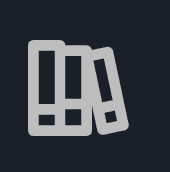

Libraries can be configured from various sources for each of your compute platforms (local Amazon SageMaker, AWS Glue, Amazon EMR etc). Library sources include PyPi, Conda, Maven, S3 and local. Compatibility is dependent on the compute selected. Refer to the library settings screen and documentation for more details. 


## Amazon Q chat assistant

Amazon Q (Free Tier) is enabled by default in Amazon SageMaker Unified Studio and can be accessed in a few ways. 

### Code Completion
Amazon Q can be enabled for code completion by selecting the Amazon Q menu at the bottom status bar of this screen. 
Q can assist with Python, PySpark, and all supported SQL.

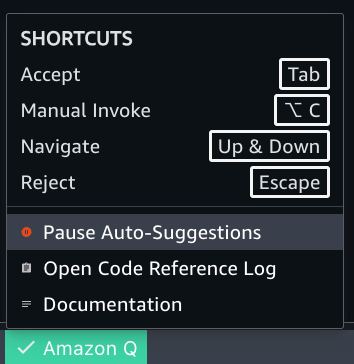


### Q chat
Q chat is available from the chat icon on the left side of your screen. 

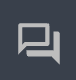

Q can assist with your code, project, data and resource questions. 

Feel free to ask Q about what it can do.